<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/Clases-4-5/notebooks/practica_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

## Aproximación por grilla

In [ ]:
def posterior_grid_approx( prior, likelihood, grid_points=100 ):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior_grid = prior( p_grid )

    # compute likelihood at each point in the grid
    likelihood_grid = likelihood( p_grid )

    # compute product of likelihood and prior
    unstd_posterior = likelihood_grid * prior_grid

    # standardize the posterior, so it sums to 1
    C = 1 / np.trapz( x=p_grid, y=unstd_posterior )
    posterior = C * unstd_posterior 
    return p_grid, prior_grid, likelihood_grid, posterior

### Modelo Beta-Bernoulli (1D)

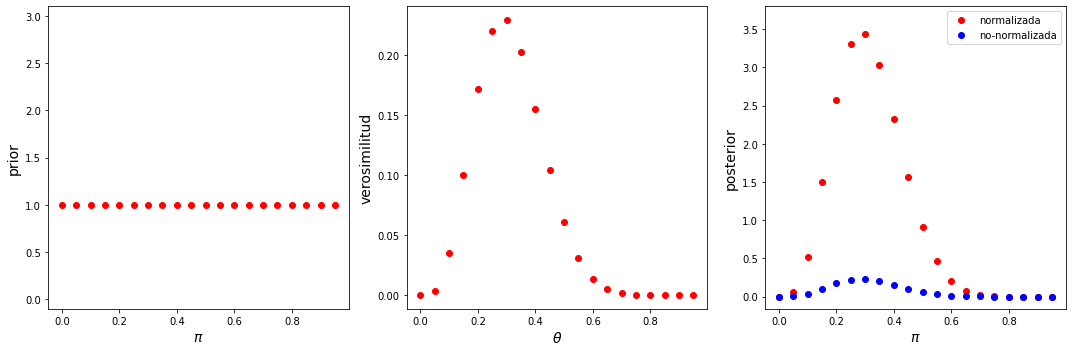

In [ ]:
T = 4 # exitos
N = 14 # total intentos

prior = lambda x: st.beta.pdf( x, a=1, b=1 ) # uniforme(0,1)
likelihood = lambda x: st.binom.pmf( T, N, x )

# define grid
dx = 0.05
p_grid = np.arange(0, 1, dx)

# define prior
prior_grid = prior( p_grid )

# compute likelihood at each point in the grid
likelihood_grid = likelihood( p_grid )

# compute product of likelihood and prior
unstd_posterior = likelihood_grid * prior_grid

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / (unstd_posterior.sum()*dx)

# Plot
fig, ax = plt.subplots( figsize=(15,5), nrows=1, ncols=3 )
ax[0].plot(p_grid, prior_grid, 'ro')
ax[0].set_xlabel(r'$\pi$', fontsize=14)
ax[0].set_ylabel('prior', fontsize=14)

ax[1].plot(p_grid, likelihood_grid, 'ro')
ax[1].set_xlabel(r'$\theta$', fontsize=14)
ax[1].set_ylabel('verosimilitud', fontsize=14)

ax[2].plot(p_grid, posterior, 'ro', label='normalizada')
ax[2].plot(p_grid, prior_grid*likelihood_grid, 'bo', label='no-normalizada')
ax[2].set_xlabel(r'$\pi$', fontsize=14)
ax[2].set_ylabel('posterior', fontsize=14)
ax[2].legend()

# ax[2].plot( p_grid, st.beta.pdf( p_grid, a=5+T, b=1.5+A ) )
ax[0].set_ylim( bottom=-0.1, top=3.1 )
ax[2].set_ylim( bottom=-0.16, top=3.8 )

fig.tight_layout()

### Modelo Normal - Normal-GammaInvesa (2D)

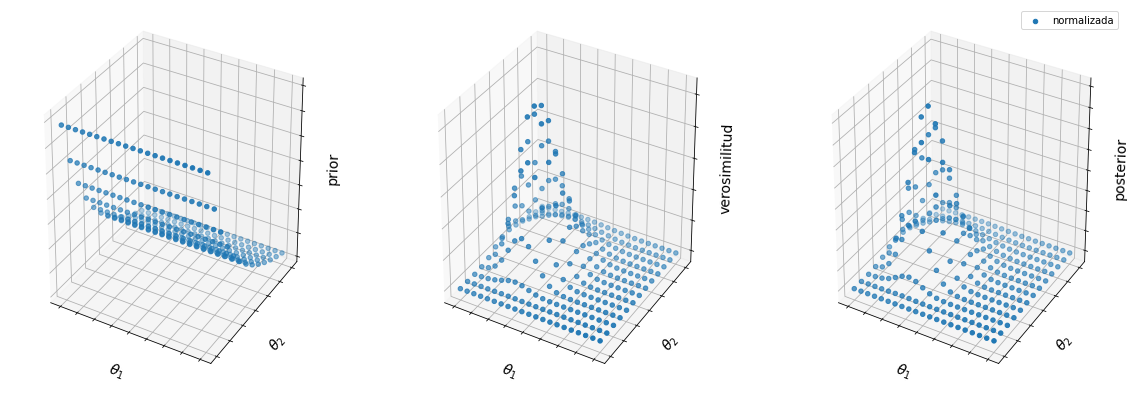

In [ ]:
N = 30
data = st.norm.rvs( size=N, loc=5, scale=1.5 )

# Non-informative prior
prior = lambda x, y: y**(-2)
# prior = lambda x, y: st.norm.pdf( x, loc=5, scale=4 ) * st.invgamma.pdf( y, 1, 1 )

def likelihood( data, x, y ):
    l = np.zeros( x.shape )
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            l[i,j] = np.sum( st.norm.logpdf( data, loc=x[i,j], scale=y[i,j] ) )
    return np.exp(l)

# Definir grilla
dx = 0.1
dy = 0.1
xgrid, ygrid = np.meshgrid( np.arange(4,6.1,dx), np.arange(0.8,2.1,dy) )

# Definir priori
prior_grid = prior( xgrid, ygrid )

# Calcular verosimilitud
likelihood_grid = likelihood( data, xgrid, ygrid )

# Calcular posterior no-normalizada
unstd_posterior = likelihood_grid * prior_grid

# Normalizar posterior
posterior = unstd_posterior/(unstd_posterior.sum()*dx*dy)

# Theoretical posterior
posterior_th = 0

# Plot
fig = plt.figure( figsize=(20,7) )

ax = fig.add_subplot( 1, 3, 1, projection='3d' )
ax.scatter( xgrid, ygrid, prior_grid )
ax.set_xlabel(r'$\theta_1$', fontsize=14)
ax.set_ylabel(r'$\theta_2$', fontsize=14)
ax.set_zlabel('prior', fontsize=14)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax = fig.add_subplot( 1, 3, 2, projection='3d' )
ax.scatter( xgrid, ygrid, likelihood_grid )
ax.set_xlabel(r'$\theta_1$', fontsize=14)
ax.set_ylabel(r'$\theta_2$', fontsize=14)
ax.set_zlabel('verosimilitud', fontsize=14)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter( xgrid, ygrid, posterior, label='normalizada')
ax.set_xlabel(r'$\theta_1$', fontsize=14)
ax.set_ylabel(r'$\theta_2$', fontsize=14)
ax.set_zlabel('posterior', fontsize=14)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.legend();

## Aproximación cuadrática

### Modelo Beta-Bernoulli

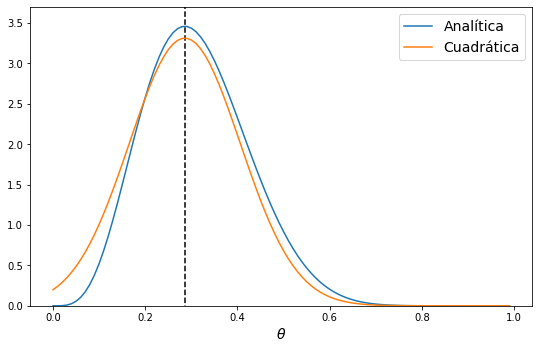

In [ ]:
from scipy.optimize import minimize

T = 4
N = 14

# Hyper-parameters
a = 1; b = 1 # Uniforme(0,1)
prior = lambda x: st.beta.pdf( x, a=a, b=b )
likelihood = lambda x: st.binom.pmf( T, N, x )
un_posterior = lambda x: -prior(x) * likelihood(x)
un_logposterior = lambda x: - np.log(prior(x)) - np.log(likelihood(x))
posterior = lambda x: st.beta.pdf( x, a=T+a, b=N-T+b) # analítica

# MAP estimate
x0 = 0.5
opt = minimize( un_logposterior, x0, method='L-BFGS-B', bounds=((0.01,1),),
                options={'ftol': 1e-5, 'disp': True} )
piMAP = opt.x[0]
vMAP = opt.hess_inv.todense()[0]
posterior_quap = st.norm( loc=piMAP, scale=np.sqrt(vMAP) )

# PLOT
xplot = np.arange( 0, 1, 0.01 )
fig, ax = plt.subplots( figsize=(9,5.5) )
ax.plot( xplot, posterior( xplot ), label='Analítica' )
ax.plot( xplot, posterior_quap.pdf(xplot), label='Cuadrática' )
ax.vlines( x=piMAP, ymin=-10, ymax=100, linestyle='--', color='k' )
ax.set_ylim([0,3.7])
ax.set_xlabel(r'$\theta$', fontsize=14)
ax.legend( fontsize=14 );

### Modelo Normal - Normal-GammaInversa

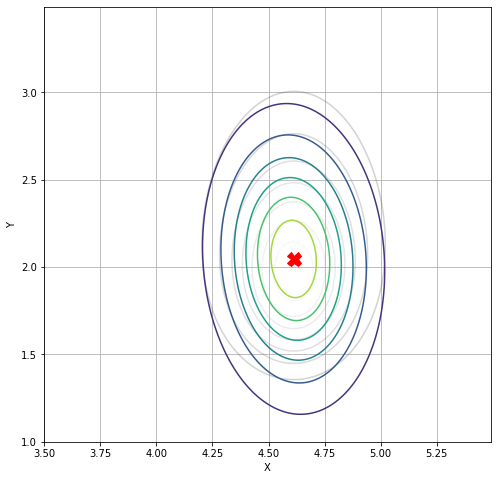

In [ ]:
# Observations
np.random.seed(1234)
mu=4.5
sigma = 1.5
N = 50
y = st.norm.rvs( size=N, loc=mu, scale=sigma )
muy = y.mean()
sy = y.std()
xgrid, ygrid = np.meshgrid( np.arange(3.5,5.5,0.01), np.arange(1,3.5,0.01) )
pos = np.dstack((xgrid, ygrid))

# Log-prior
logprior = lambda mu, s2: s2**(-1)

# Log-Likelihood
loglikelihood = lambda mu, s2: np.sum( st.norm.logpdf( y, loc=mu, scale=np.sqrt(s2) ) )

def likelihood_grid( x, y ):
    l = np.zeros( x.shape )
    for i in range(x.shape[0]):
        for j in range(xgrid.shape[1]):
            l[i,j] = loglikelihood( x[i,j], y[i,j] )
    return np.exp(l)

# Posterior conjugada
s2_cond_y_post = st.invgamma( a=(N-1)/2, scale=(N-1)*sy**2/2 )
# Conditional posterior of mean given observations and standard deviation
mu_cond_s2_y_post = lambda s2: st.norm( loc=muy, scale=np.sqrt( s2/N ) )
# Log-posterior no normalizada
un_logposterior = lambda x: - loglikelihood( x[0], x[1] ) - logprior( x[0], x[1] )
# Posterior analítica
posterior = lambda mu, s2: s2_cond_y_post.pdf( s2 ) * mu_cond_s2_y_post( s2 ).pdf( mu )

# Aproximación cuadrática
x0 = np.array([3.75,3])
xii = np.array([x0[0],x0[1]])
opt = minimize( un_logposterior, x0, method='L-BFGS-B',
                options={'ftol': 1e-5, 'disp': True} )
piMAP = opt.x
vMAP = opt.hess_inv.todense()
posterior_quap = st.multivariate_normal( mean=piMAP, cov=vMAP )
pos = np.dstack((xgrid, ygrid))

fig, ax = plt.subplots( figsize=(8,8) )
ax.contour(xgrid, ygrid, posterior( xgrid, ygrid ), cmap='gray', alpha=0.2)
# ax.plot( xii[:,0], xii[:,1], color='b', marker='s', markersize=12 )
# ax.plot( xii[0,0], xii[0,1], color='r', marker='s', markersize=12 )
ax.contour(xgrid, ygrid, posterior_quap.pdf( pos ), cmap='viridis')
ax.plot( piMAP[0], piMAP[1], 'rX', markersize=14 )
ax.grid()
ax.set_xlabel('X')
ax.set_ylabel('Y');

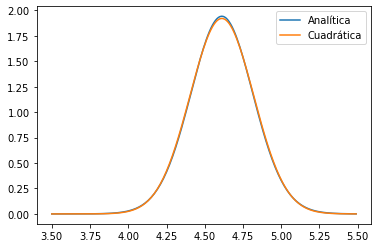

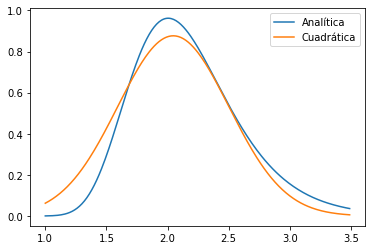

In [ ]:
# Marginales
mu_post_analytic = st.t( N-1, loc=muy, scale=sy*np.sqrt(1/N) )
mu_post_quap = st.norm( loc=piMAP[0], scale=np.sqrt(vMAP[0,0]) )
s2_post_quap = st.norm( loc=piMAP[1], scale=np.sqrt(vMAP[1,1]) )


# Plot
mu_plot = np.unique( xgrid )
s2_plot = np.unique( ygrid )

fig, ax = plt.subplots()
ax.plot( mu_plot, mu_post_analytic.pdf(mu_plot), label='Analítica' )
ax.plot( mu_plot, mu_post_quap.pdf(mu_plot), label='Cuadrática' )
ax.legend();

fig, ax = plt.subplots()
ax.plot( s2_plot, s2_cond_y_post.pdf(s2_plot), label='Analítica' )
ax.plot( s2_plot, s2_post_quap.pdf(s2_plot), label='Cuadrática' )
ax.legend();

## MCMC

### Modelo Beta-Bernoulli

Mi primer cadena de MCMC!!!

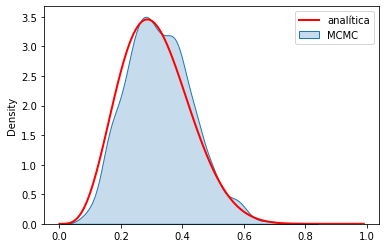

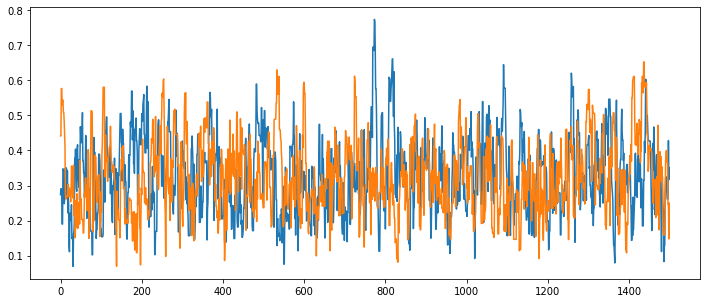

In [ ]:
T = 4
N = 14

# Hyper-parameters
a = 1; b = 1 # Uniforme(0,1)
prior = lambda x: st.beta.pdf( x, a=a, b=b )
likelihood = lambda x: st.binom.pmf( T, N, x )
un_posterior = lambda x: prior(x) * likelihood(x)
un_logposterior = lambda x: - np.log(prior(x)) - np.log(likelihood(x))
posterior = lambda x: st.beta.pdf( x, a=T+a, b=N-T+b) # analítica

# MCMC chain parameters
target = un_posterior
step = 0.1
Nsim = 3000
Nchains = 2
x0 = 0.03

accepted = np.zeros([Nchains,Nsim])
accepted[0] = x0
proposal = np.zeros([Nchains,Nsim])
proposal[0] = x0
for j in range(Nchains):
  for i in range(1,Nsim):
      # Proposal
      jump = st.norm( loc=x0, scale=step )
      proposal[j,i] = jump.rvs( size=1 )[0]
      # accept
      r = target( proposal[j,i] ) / target( x0 ) # symmetrical jump!
      if np.random.random() < r:
          x0 = proposal[j,i]
      else:
          x0 = x0
      # Update accepted
      accepted[j,i] = x0

# Burn-in
burnin = int(Nsim/2)
t_burnin = accepted[:,burnin:]
t_mcmc = t_burnin.flatten()

# Plot
xplot = np.arange( 0, 1, 0.01 )
fig, ax = plt.subplots()
ax.plot( xplot, posterior( xplot ), color='r', linewidth=2, label='analítica' )
sns.kdeplot( t_mcmc, fill=True, label='MCMC', ax=ax )
ax.legend()

# MCMC diagnostics
fig, ax = plt.subplots( figsize=(12,5) )
ax.plot( t_burnin.T, label='chains' );

Usando PyMC3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


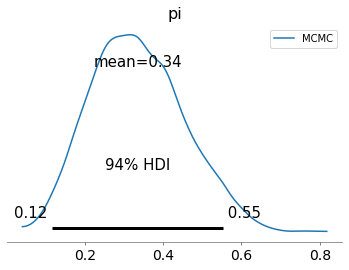

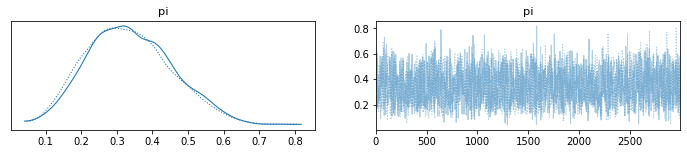

In [2]:
# !pip install pymc
import pymc as pm
import arviz as az

# Obsrevaciones binarias
y = np.array([0,0,1,0,0,0,1,1,0,1,0,0,0])

# Simulación (PyMC3)
with pm.Model() as model:
    # Prior
    pi = pm.Uniform('pi', lower=0, upper=1 )
    # Verosimilitud
    y = pm.Bernoulli('y', p=pi, observed=y)
    # MCMC
    trace = pm.sample(3000, tune=1000, cores=2, return_inferencedata=True)

# Plot posterior
xplot = np.arange( 0, 1, 0.01 )
fig, ax = plt.subplots()
# ax.plot( xplot, posterior( xplot ), color='r', linewidth=2, label='analítica' )
az.plot_posterior(trace, ax=ax, label='MCMC')
ax.legend();

# MCMC diagnostic
az.plot_trace(trace);

### Modelo Normal - Normal-GammaInversa

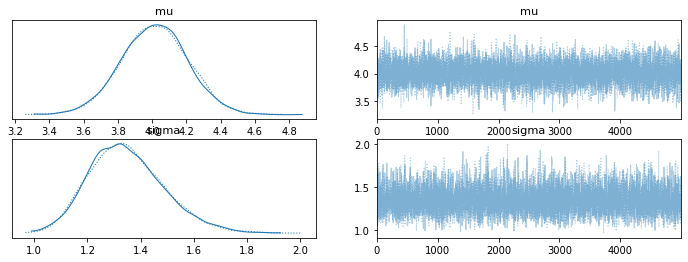

In [3]:
# Observaciones
mu = 4.5
sigma = 1.5
N = 50
y = st.norm.rvs( size=N, loc=mu, scale=sigma )
muy = y.mean()
sy = y.std()
xgrid, ygrid = np.meshgrid( np.arange(3.5,5.5,0.01), np.arange(1,3.5,0.01) )
pos = np.dstack((xgrid, ygrid))

# Simulación (PyMC3)
with pm.Model() as model:
    # Prior
    mu = pm.Normal('mu', mu=0, sigma=10 )
    sigma = pm.HalfNormal('sigma', sigma=2 )
    # Verosimilitud
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
    # MCMC
    trace = pm.sample(5000, tune=1000, cores=2, return_inferencedata=True)

# MCMC diagnostic
az.plot_trace(trace)
az.plot_posterior(trace, label='MCMC');

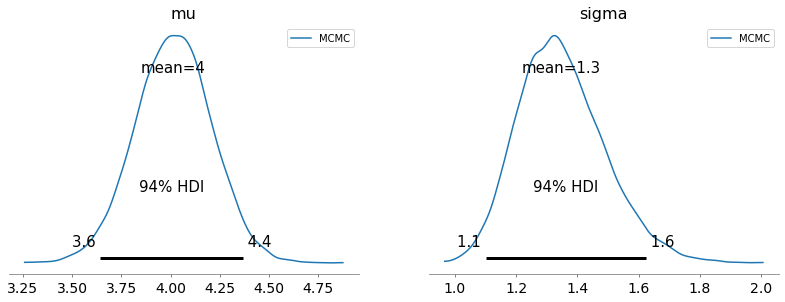

In [4]:
az.plot_posterior(trace, label='MCMC');
